# Physics Informed Neural Network (PINN) Examples


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

In [3]:
from src.models import FCN
from src.data_handler import DataHandler, RandomSamplingDataHandler
from src.experiment_run import Run

In [4]:
torch.manual_seed(123)

# Practical Exercise

In [5]:
def oscillator(d, w0, x):
    """Defines the analytical solution from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


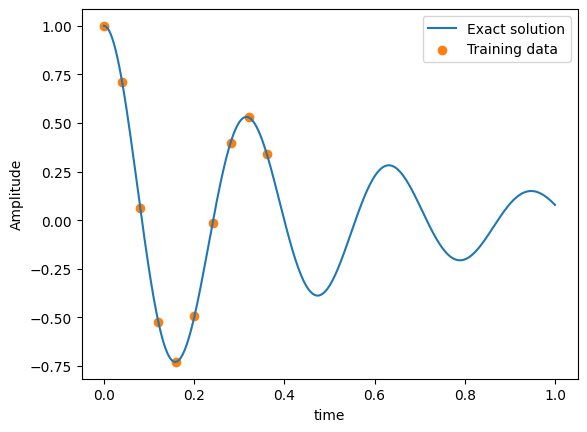

In [6]:
d, w0 = 2, 20
m = 1
mu, k = 2*m*d, m*w0**2

# get the analytical solution over the full domain
x = torch.linspace(0, 1, 500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.xlabel('time'), plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [7]:
def physics_loss_fn(x, y, loss_coef=1.):
    # compute dy/dx
    dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x, torch.ones_like(dx),  create_graph=True)[0]

    # compute the physic loss
    ode = dx2 + mu*dx + k*y

    return loss_coef * torch.mean(ode ** 2)

In [15]:
model = FCN([1, 32, 32, 1], torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=100,)

run = Run('linspace_physics_data')

run.data_handler = DataHandler(x, y, 200, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=0.0001)

run.train(20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [02:17<00:00, 145.48it/s]


In [16]:
model = FCN([1, 8, 8, 1], torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=200,)

run = Run('random_sample_physics_data')

run.data_handler = RandomSamplingDataHandler(x, y, 200, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=0.0001)

run.train(20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [01:12<00:00, 274.37it/s]
